In [1]:
import sys, os
sys.path.append(os.path.abspath('../src'))

# Load environment variables
from dotenv import load_dotenv
load_dotenv('../.env')

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np
from data.preprocess import preprocess_price_matrix
from data.loader import get_multiple_stocks
from models.svd import rolling_svd_factors, plot_component_series, plot_asset_loading, plot_explained_variance, plot_cumulative_explained_variance
from models.forecast import forecast_components_arima
from signals.scoring import generate_signals_from_forecast

In [2]:
s_and_p_500_constituents = pd.read_csv('../cache/constituents.csv')
nasdaq_100_constituents = pd.read_csv('../cache/nasdaq-100.csv')
active_tickers = sorted(list(set(s_and_p_500_constituents['Symbol'].dropna()) | set(nasdaq_100_constituents['Symbol'].dropna())))
active_tickers

['A',
 'AAPL',
 'ABBV',
 'ABNB',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APO',
 'APP',
 'APTV',
 'ARE',
 'ARM',
 'ASML',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BF.B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK.B',
 'BRO',
 'BSX',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCEP',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'C

In [4]:
# Get all the data
stock_data = get_multiple_stocks(active_tickers, update=False, rate_limit=5.0)


Fetching data for A...
Fetching data for AAPL...
Fetching data for ABBV...
Fetching data for ABNB...
Fetching data for ABT...
Fetching data for ACGL...
Fetching data for ACN...
Fetching data for ADBE...
Fetching data for ADI...
Fetching data for ADM...
Fetching data for ADP...
Fetching data for ADSK...
Fetching data for AEE...
Fetching data for AEP...
Fetching data for AES...
Fetching data for AFL...
Fetching data for AIG...
Fetching data for AIZ...
Fetching data for AJG...
Fetching data for AKAM...
Fetching data for ALB...
Fetching data for ALGN...
Fetching data for ALL...
Fetching data for ALLE...
Fetching data for AMAT...
Fetching data for AMCR...
Fetching data for AMD...
Fetching data for AME...
Fetching data for AMGN...
Fetching data for AMP...
Fetching data for AMT...
Fetching data for AMZN...
Fetching data for ANET...
Fetching data for ANSS...
Fetching data for AON...
Fetching data for AOS...
Fetching data for APA...
Fetching data for APD...
Fetching data for APH...
Fetching dat

In [5]:
stock_data

{'Open': symbol           A    AAPL    ABBV    ABNB     ABT   ACGL     ACN    ADBE  \
 date                                                                        
 2020-08-03   96.94  108.20   95.19     NaN  101.08  30.80  225.00  449.84   
 2020-08-04   98.71  109.13   95.92     NaN  100.16  31.06  226.29  448.26   
 2020-08-05   98.09  109.38   94.47     NaN   99.97  30.53  227.94  449.09   
 2020-08-06   97.72  110.40   93.32     NaN  101.52  30.59  227.68  451.35   
 2020-08-07   97.07  113.21   92.69     NaN  101.70  31.18  229.25  460.87   
 ...            ...     ...     ...     ...     ...    ...     ...     ...   
 2025-07-28  119.41  214.03  191.21  141.30  126.15  88.58  280.19  371.03   
 2025-07-29  119.75  214.18  189.15  142.17  126.01  87.21  277.45  370.45   
 2025-07-30  120.24  211.90  191.77  135.90  127.97  89.83  278.50  370.68   
 2025-07-31  116.57  208.49  197.06  134.75  127.54  85.35  271.00  362.26   
 2025-08-01  113.45  210.87  189.92  130.04  125.47  86.

In [6]:
# Access individual DataFrames
open_prices = stock_data['Open']      # DataFrame with Open prices for all stocks
high_prices = stock_data['High']      # DataFrame with High prices for all stocks
low_prices = stock_data['Low']        # DataFrame with Low prices for all stocks
close_prices = stock_data['Close']    # DataFrame with Close prices for all stocks
volumes = stock_data['Volume']        # DataFrame with Volume for all stocks

In [7]:
# === SVD Signal Pipeline ===
pre_scaled = preprocess_price_matrix(close_prices, winsorize_span=40)

Dropped assets due to lookback_days requirement:
['ABNB', 'APP', 'ARM', 'CEG', 'DASH', 'EXE', 'GEHC', 'GEV', 'GFS', 'GRAL', 'HOOD', 'KVUE', 'PLTR', 'SOLV', 'VLTO']


/mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/anaconda3/envs/svd_forecasting/lib/python3.10/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Total values winsorized: 2,209


In [7]:
loadings_df, components_df, explained_var_df = rolling_svd_factors(
    X=pre_scaled,
    dates=pre_scaled.index,
    assets=pre_scaled.columns,
    window_size=180,
    n_components=10
)

In [ ]:
# components_df.write_pickle('../results/components.pkl')
# components_df.to_pickle('../results/components.pkl')


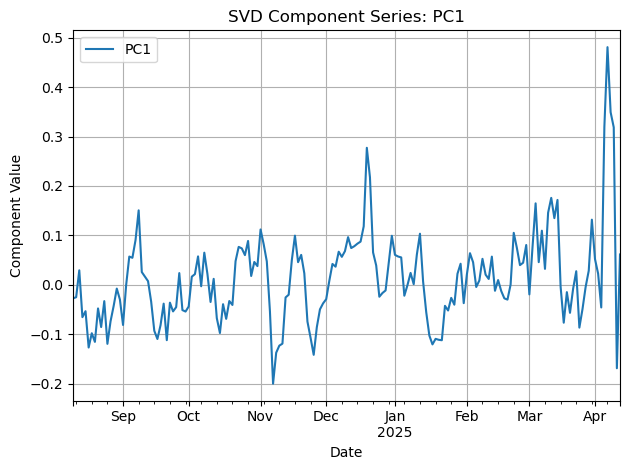

In [8]:
plot_component_series(components_df.iloc[-176:], components='PC1')

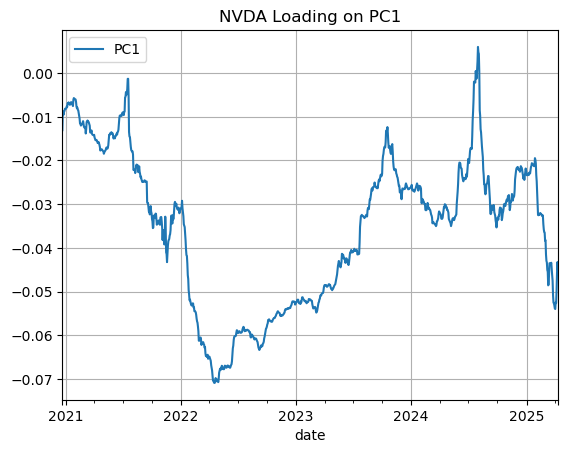

In [9]:
plot_asset_loading(loadings_df, asset_name='NVDA', component='PC1')

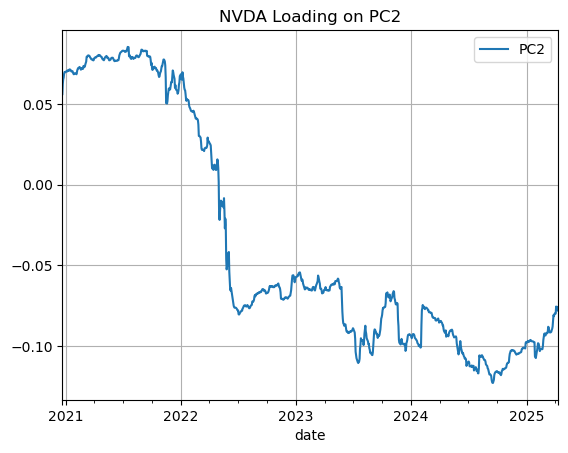

In [13]:
plot_asset_loading(loadings_df, asset_name='NVDA', component='PC2')

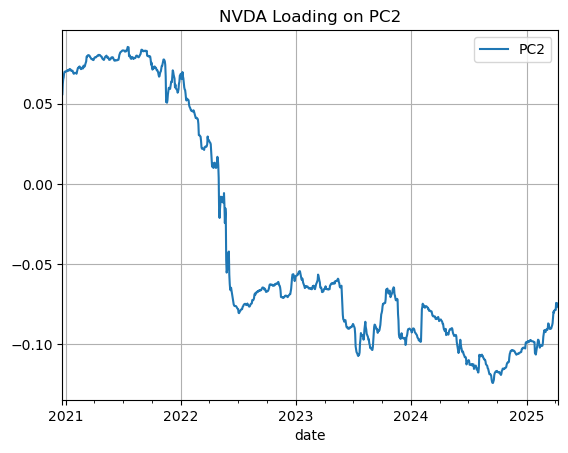

In [10]:
plot_asset_loading(loadings_df, asset_name='NVDA', component='PC2')

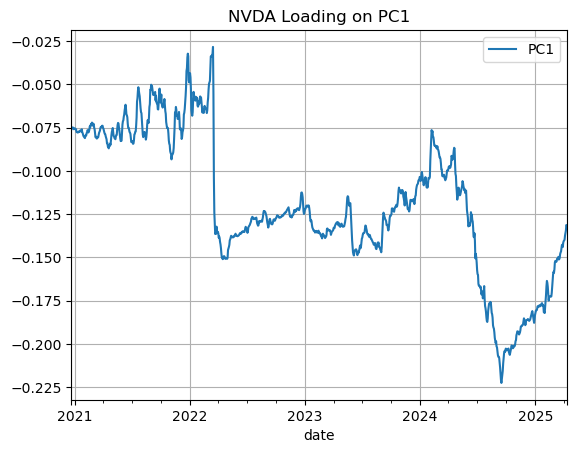

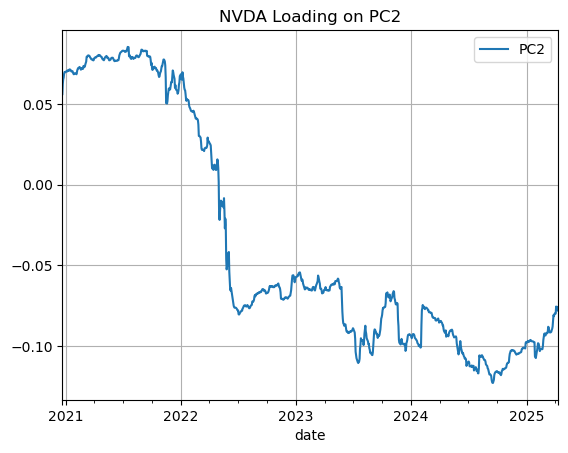

In [14]:
plot_asset_loading(loadings_df, asset_name='NVDA', component='PC2')

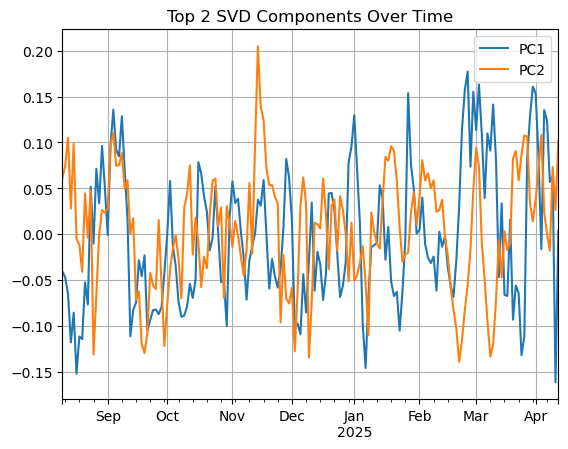

In [159]:
# plot_component_series(components_df.iloc[-176:], n=2)

In [160]:
# loadings_df.xs('AAPL', level='asset')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
date,,,,,,,,,,
2020-12-22,-0.066167,-0.053926,-0.036025,0.035697,0.013733,-0.036227,0.070461,0.050406,-0.052129,-0.045660
2020-12-23,-0.066543,-0.054246,-0.033826,0.039008,0.014137,-0.032996,0.072333,0.056137,-0.055796,-0.034102
2020-12-24,-0.066178,-0.055156,-0.032858,0.040749,0.013749,-0.032796,0.069669,0.063095,-0.058366,-0.018591
2020-12-25,-0.066592,-0.055541,-0.032872,0.041492,0.015310,-0.031799,0.068972,0.068497,-0.050694,-0.020855
2020-12-28,-0.066807,-0.054612,-0.038173,0.044754,0.023241,-0.027975,0.069664,0.076068,-0.020456,-0.034945
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,0.002398,-0.014825,-0.087446,-0.028179,0.034817,0.029725,-0.066793,-0.001716,0.066670,-0.006579
2025-04-08,0.001890,-0.014559,-0.083478,-0.018698,0.037363,0.036605,-0.068496,-0.003032,0.070472,0.004325
2025-04-09,0.001115,-0.015339,-0.081300,-0.008320,0.039103,0.038896,-0.074762,-0.006211,0.074301,0.014764


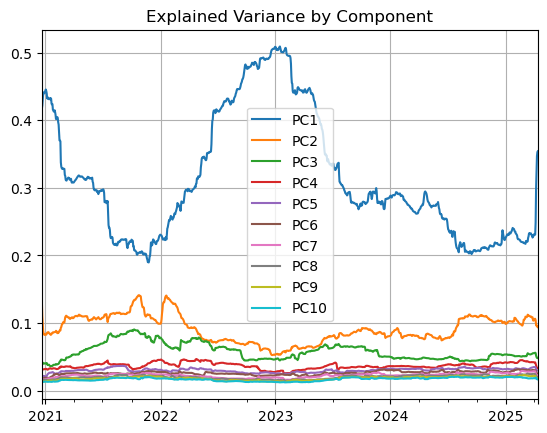

In [11]:
plot_explained_variance(explained_var_df)

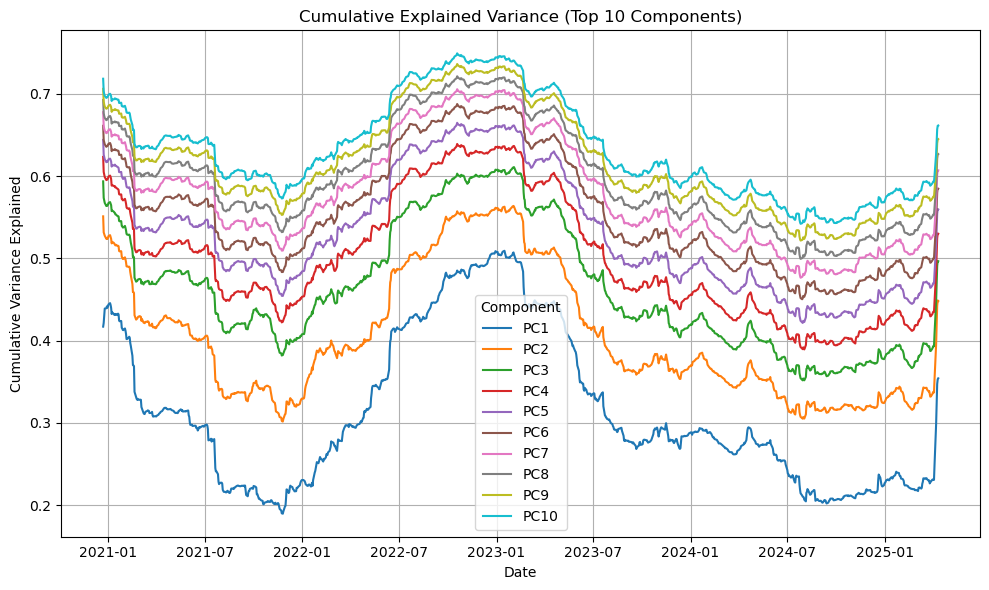

In [12]:
plot_cumulative_explained_variance(explained_var_df)

In [13]:
from pmdarima import auto_arima



In [20]:
loadings_df 

PC1       PC2       PC3       PC4       PC5       PC6  \
date       asset                                                               
2020-12-22 A     -0.030582  0.046914 -0.023527  0.010477 -0.007887  0.027350   
           AAPL  -0.022696  0.075633 -0.063109 -0.010692  0.098522  0.022971   
           ABBV  -0.026253  0.032323 -0.021384 -0.108303 -0.035472  0.012350   
           ABT   -0.022218  0.092417  0.034610 -0.004765 -0.031119  0.013014   
           ACGL  -0.065955 -0.054231  0.026923  0.039306  0.042011  0.108474   
...                    ...       ...       ...       ...       ...       ...   
2025-04-11 YUM   -0.031138  0.071827 -0.023929 -0.083703  0.040460 -0.009147   
           ZBH   -0.028877  0.041194  0.030735  0.073306 -0.032038 -0.048996   
           ZBRA  -0.065330 -0.033092  0.028485  0.046800  0.017537  0.033595   
           ZS    -0.038238 -0.029089  0.001591  0.003899  0.006116  0.019685   
           ZTS   -0.029289  0.060746  0.020455  0.005314  0.031856  0.066155   

                       PC7       PC8       PC9      PC10  
date       asset                                          
2020-12-22 A     -0.022114  0.029210  0.019796 -0.046487  
           AAPL  -0.038491 -0.038494 -0.052232  0.023120  
           ABBV   0.017982  0.014621  0.040660  0.032005  
           ABT    0.007823  0.049092 -0.002762  0.056726  
           ACGL  -0.046553 -0.004121 -0.055246 -0.083275  
...                    ...       ...       ...       ...  
2025-04-11 YUM   -0.074207 -0.051506  0.103432  0.028373  
           ZBH    0.038180  0.001147 -0.003790 -0.002350  
           ZBRA   0.080333 -0.045257  0.006314 -0.057821  
           ZS    -0.055186  0.010701 -0.009157  0.061732  
           ZTS    0.046201 -0.049975 -0.029911 -0.036773  

[564248 rows x 10 columns]

In [14]:
forecast_deltas = forecast_components_arima(components_df, horizon=10)

In [18]:
from signals.scoring import generate_signals_from_forecast

forecast_deltas 

,forecast_delta,order,aic,forecast_path
component,,,,
PC1,0.136777,"(2, 0, 0)",-3224.464809,2025-04-14 0.052914 2025-04-15 0.033458 ...
PC2,-0.100417,"(1, 0, 0)",-3593.497196,2025-04-14 -0.030264 2025-04-15 -0.021432 ...
PC3,-0.266105,"(1, 0, 0)",-3561.340239,2025-04-14 -0.086001 2025-04-15 -0.058831 ...
PC4,0.020427,"(1, 0, 0)",-3849.503988,2025-04-14 0.005399 2025-04-15 0.004053 ...
PC5,-0.091109,"(1, 0, 1)",-3930.025361,2025-04-14 -0.023442 2025-04-15 -0.017793 ...
PC6,0.439592,"(1, 0, 3)",-3757.533464,2025-04-14 0.150937 2025-04-15 0.109723 ...
PC7,-0.288424,"(2, 0, 0)",-3826.810157,2025-04-14 -0.092994 2025-04-15 -0.065242 ...
PC8,0.627315,"(2, 0, 1)",-3733.206692,2025-04-14 0.162030 2025-04-15 0.122934 ...
PC9,0.104147,"(2, 0, 0)",-3860.425896,2025-04-14 0.014290 2025-04-15 0.012428 ...


In [17]:
longs, shorts, scores = generate_signals_from_forecast(loadings_df, forecast_deltas, components_df.index[-1], n_assets=10)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 14 is different from 10)

In [19]:
 components_df.index[-1]

Timestamp('2025-04-11 00:00:00')

In [26]:
signal_series[shorts]

asset
IP     -0.092351
MTD    -0.093891
LYB    -0.096550
APA    -0.096843
DOW    -0.104228
BAX    -0.105120
COP    -0.105665
BMY    -0.112478
GRMN   -0.130540
ABBV   -0.168167
dtype: float64

In [184]:
[forecast_deltas.set_index('component').get(f'PC{i+1}', 0) for i in range(len(forecast_deltas))]

KeyError: "None of ['component'] are in the columns"

In [187]:
forecast_deltas.get('PC1')

In [190]:
forecast_deltas.loc['PC1', 'forecast_delta']

0.007829254923277398

In [ ]:
plot_asset_loading(loadings_df, 'NVDA', component='PC1')

In [ ]:
loadings_df 